In [1]:
#the imports I used
import marvin
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from marvin.utils.general import mangaid2plateifu

from astropy.constants import c

from astropy.io import fits

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')


[WARNING]: /opt/conda/lib/python3.11/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),

[INFO]: No release version set. Setting default to DR17
[WARNING]: /opt/conda/lib/python3.11/site-packages/marvin/__init__.py:387: MarvinUserWarning: path /home/jovyan/sas/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None.
  warnings.warn('path {0} cannot be found. Setting drpall to None.'

[WARNING]: /opt/conda/lib/python3.11/site-packages/marvin/__init__.py:400: MarvinUserWarning: path /home/jovyan/sas/dr17/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None.
  warnings.warn('path {0} cannot be found. Setting dapall to None.'



In [2]:
#Constants
HALPHA_REST = 6563.0  # Å
SPEED_OF_LIGHT = c.to('km/s').value
kenn_sfr_coeff = 7.9e-42

In [3]:
  def gaussian(x, A, mu, sigma):
    return A*np.exp(-0.5*((x-mu)/sigma)**2)

def multi_gaussian(x, *params):
    """Sum of multiple Gaussian functions."""
    n_gaussians = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n_gaussians):
        amp, mu, sigma = params[i*3:(i+1)*3]
        y += amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y

def calculate_redshifts(observed_wavelengths, rest_wavelengths):
    # Compute redshift for every (observed, rest-frame) pair
    redshifts = (np.array(observed_wavelengths)[:, None] - np.array(rest_wavelengths)) / np.array(rest_wavelengths)
    for i, obs in enumerate(observed_wavelengths):
        for j, rest in enumerate(rest_wavelengths):
            print(f"Redshift from observed {obs:.2f} Å to rest {rest:.0f} Å: {redshifts[i, j]:.5f}")
    return redshifts

def fit_line(wave, flux, center=HALPHA_REST, window=20):
    mask = (wave > center - window) & (wave < center + window)
    x = wave[mask]
    y = flux[mask]

    # Lorentzian function
    def lorentzian(x, amp, cen, wid):
        return amp / (1 + ((x - cen) / wid) ** 2)

    # Initial guess for Lorentzian fit
    p0 = [np.max(y), center, 1.0]  # Amp = max value, center = HALPHA_REST, wid = 1.0

    try:
        # Perform Lorentzian fitting with a max number of function evaluations
        popt, _ = curve_fit(lorentzian, x, y, p0=p0, maxfev=10000)
        return popt[1]  # Return the fitted center (line_center)
    except Exception as e:
        print(f"Fit failed: {e}")
        return np.nan  # Return np.nan if fit fails


def redshift_to_velocity(z):
    """Convert redshift to velocity using relativistic Doppler formula."""
    c = 299792.458  # Speed of light in km/s
    velocity = c * ((1 + z)**2 - 1) / ((1 + z)**2 + 1)
    return velocity

def compute_sfr(ha_flux, distance_mpc):
    """
    Compute star formation rate (SFR) from H-alpha flux.

    Parameters:
    - ha_flux : float or array-like
        Observed H-alpha flux in erg/s/cm²
    - distance_mpc : float
        Distance to galaxy in Megaparsecs (Mpc)

    Returns:
    - SFR in solar masses per year (M☉/yr)
    """
    # Convert distance to cm (1 Mpc = 3.085677581e24 cm)
    distance_cm = distance_mpc * 3.085677581e24
    
    # Compute luminosity (L = 4 * π * d² * F)
    ha_luminosity = 4 * np.pi * (distance_cm ** 2) * ha_flux

    # Compute SFR using Kennicutt (1998) relation
    sfr = kenn_sfr_coeff * ha_luminosity
    return sfr

In [4]:
Gal = marvin.tools.Cube(filename = 'manga-8459-12702-LOGCUBE.fits.gz')



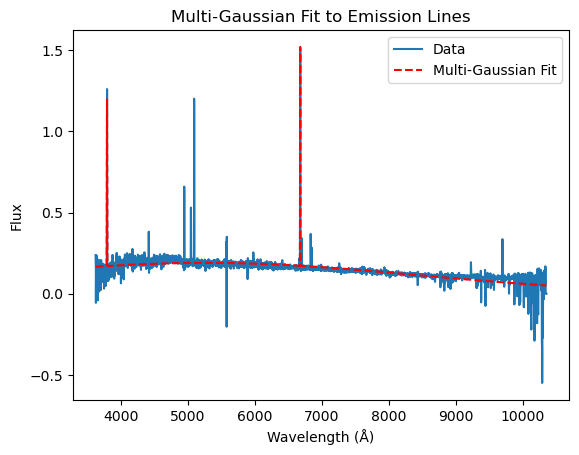

In [14]:
wave = Gal.flux.wavelength.to_value()  # Convert wavelengths to unitless numpy array
flux = Gal.flux.value
shape = flux.shape
x0, y0 = shape[1] // 2, shape[2] // 2

spectrum = Gal.flux.value[:, y0, x0]  # Extract spectrum
spectrum = np.array(spectrum)  # Ensure it's a simple numpy array


peak_indices = np.argsort(spectrum)[-3:]  # Get top three peak locations
initial_guesses = [
    np.max(spectrum), wave[peak_indices[2]], 5,
    np.max(spectrum)/2, wave[peak_indices[1]]+1600, 5,
    np.max(spectrum)/3, wave[peak_indices[0]], 5
]

# Fit multiple Gaussians to spectrum
popt, _ = curve_fit(multi_gaussian, wave, spectrum, p0=initial_guesses, maxfev = 10000)

# Plot results
plt.plot(wave, spectrum, label="Data")
plt.plot(wave, multi_gaussian(wave, *popt), linestyle="--", color="red", label="Multi-Gaussian Fit")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.title("Multi-Gaussian Fit to Emission Lines")
plt.show()

In [15]:
observed_wavelengths = [popt[1], popt[4], popt[7]]  # Fitted peaks
rest_wavelengths = [6563, 5007, 4861]  # H-alpha, [O III], H-beta

redshift_values = calculate_redshifts(observed_wavelengths, rest_wavelengths)

Redshift from observed 6676.75 Å to rest 6563 Å: 0.01733
Redshift from observed 6676.75 Å to rest 5007 Å: 0.33348
Redshift from observed 6676.75 Å to rest 4861 Å: 0.37353
Redshift from observed 5275.87 Å to rest 6563 Å: -0.19612
Redshift from observed 5275.87 Å to rest 5007 Å: 0.05370
Redshift from observed 5275.87 Å to rest 4861 Å: 0.08535
Redshift from observed 3792.53 Å to rest 6563 Å: -0.42213
Redshift from observed 3792.53 Å to rest 5007 Å: -0.24255
Redshift from observed 3792.53 Å to rest 4861 Å: -0.21980


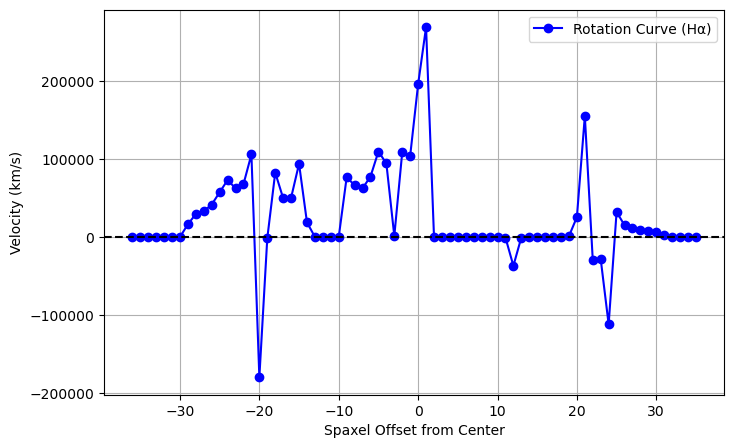

In [16]:


# Measure Hα centroid for each spaxel
vel_map = np.full((shape[1], shape[2]), np.nan)
for i in range(shape[1]):
    for j in range(shape[2]):
        spectrum = flux[:, i, j]
        line_center = fit_line(wave, spectrum)
        if not np.isnan(line_center):
            z = (line_center - HALPHA_REST) / HALPHA_REST
            vel = z * SPEED_OF_LIGHT
            vel_map[i, j] = vel

# Compute velocity along the galaxy's major axis (horizontal slice)
major_axis = vel_map[:, y0]
radius = np.arange(len(major_axis)) - x0

# Plot the rotation curve
plt.figure(figsize=(8, 5))
plt.plot(radius, major_axis, 'bo-', label='Rotation Curve (Hα)')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Spaxel Offset from Center')
plt.ylabel('Velocity (km/s)')

plt.grid(True)
plt.legend()
plt.show()


In [17]:
y0, x0 = Gal.flux.shape[1:]  # Get the spatial dimensions (Y, X) of the cube
velocity_map = np.full((y0, x0), np.nan)

for y in range(y0):
    for x in range(x0):
        spectrum = np.array(Gal.flux.value[:, y, x])
        if np.nanmean(spectrum) < 1e-17:  # Skip low signal
            continue
        
        # Fit Gaussian to the spectrum at this spaxel
        try:
            velocities = fit_emission_lines(Gal.flux.wavelength.to_value(), spectrum)
            velocity_map[y, x] = velocities[0]  # Using Hα velocity
        except Exception as e:
            continue


In [18]:


log_OIII_Hbeta_all = []
log_NII_Halpha_all = []

for y in range(y0):
    for x in range(x0):
        try:
            spectrum = np.array(Gal.flux.value[:, y, x])
            popt, _ = curve_fit(multi_gaussian, wave, spectrum, p0=initial_guesses)

            # Extract fitted fluxes from Gaussian amplitudes
            H_alpha_flux = popt[0]
            N_II_flux = popt[3]
            H_beta_flux = popt[6]
            O_III_flux = popt[3]  # Adjusted for missing Gaussian

            # Compute log ratios for BPT diagram
            log_OIII_Hbeta_all.append(np.log10(O_III_flux / H_beta_flux))
            log_NII_Halpha_all.append(np.log10(N_II_flux / H_alpha_flux))
        except:
            continue

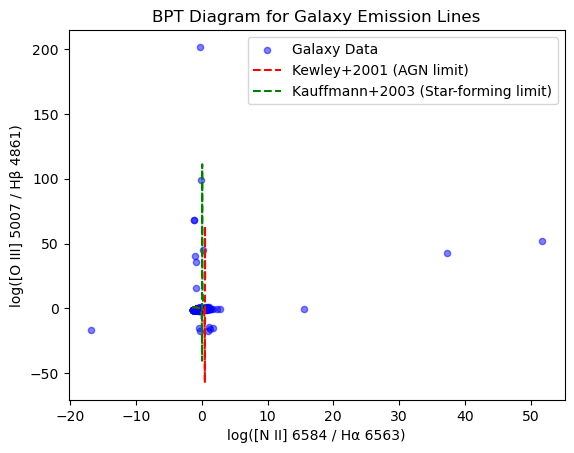

In [19]:


x_vals = np.linspace(-1.5, 0.5, 100)  # X-axis range

# Kewley+2001 AGN boundary
kewley_boundary = 0.61 / (x_vals - 0.47) + 1.19

# Kauffmann+2003 star-forming boundary
kauffmann_boundary = 0.61 / (x_vals - 0.05) + 1.3

# Plot BPT diagram with curved boundaries
plt.scatter(log_NII_Halpha_all, log_OIII_Hbeta_all, color='blue', alpha=0.5, s=20, label="Galaxy Data")
plt.plot(x_vals, kewley_boundary, linestyle="--", color="red", label="Kewley+2001 (AGN limit)")
plt.plot(x_vals, kauffmann_boundary, linestyle="--", color="green", label="Kauffmann+2003 (Star-forming limit)")

plt.xlabel(r"log([N II] 6584 / Hα 6563)")
plt.ylabel(r"log([O III] 5007 / Hβ 4861)")
plt.title("BPT Diagram for Galaxy Emission Lines")
plt.legend()
plt.show()

In [20]:
y0, x0 = shape[1], shape[2]
H_alpha_map = np.full((y0, x0), np.nan)
H_beta_map = np.full((y0, x0), np.nan)


# Constants
HALPHA_REST = 6563.0  # Å
SPEED_OF_LIGHT = 3e5  # km/s
c = SPEED_OF_LIGHT

def single_gaussian(x, amp, cen, sigma):
    return amp * np.exp(-(x - cen)**2 / (2 * sigma**2))

shape = Gal.flux.shape
wave = Gal.flux.wavelength.to_value()
flux = Gal.flux.value

y0, x0 = shape[1], shape[2]
H_alpha_flux_map = np.full((y0, x0), np.nan)
H_beta_flux_map = np.full((y0, x0), np.nan)

for y in range(y0):
    for x in range(x0):
        spectrum = flux[:, y, x]
        if np.nanmean(spectrum) < 1e-17:
            continue

        # Fit Hα region around expected wavelength (z ~ 0.03)
        z_est = 0.03
        expected_Ha = HALPHA_REST * (1 + z_est)
        mask_ha = (wave > expected_Ha - 50) & (wave < expected_Ha + 50)
        wave_cut_ha = wave[mask_ha]
        spectrum_cut_ha = spectrum[mask_ha]

        amp_guess = np.nanmax(spectrum_cut_ha)
        cen_guess = expected_Ha
        sigma_guess = 3

        try:
            popt_ha, _ = curve_fit(single_gaussian, wave_cut_ha, spectrum_cut_ha,
                                   p0=[amp_guess, cen_guess, sigma_guess])
            H_alpha_flux_map[y, x] = popt_ha[0] * popt_ha[2] * np.sqrt(2 * np.pi)
        except:
            continue

        # Fit Hβ region
        Hbeta_rest = 4861.0
        expected_Hb = Hbeta_rest * (1 + z_est)
        mask_hb = (wave > expected_Hb - 50) & (wave < expected_Hb + 50)
        wave_cut_hb = wave[mask_hb]
        spectrum_cut_hb = spectrum[mask_hb]

        amp_guess_hb = np.nanmax(spectrum_cut_hb)
        cen_guess_hb = expected_Hb
        sigma_guess_hb = 3

        try:
            popt_hb, _ = curve_fit(single_gaussian, wave_cut_hb, spectrum_cut_hb,
                                   p0=[amp_guess_hb, cen_guess_hb, sigma_guess_hb])
            H_beta_flux_map[y, x] = popt_hb[0] * popt_hb[2] * np.sqrt(2 * np.pi)
        except:
            continue

# === Compute total observed flux in erg/s/cm^2 ===
fwhm = 10  # Å
H_alpha_total_flux = np.nansum(H_alpha_flux_map) * fwhm  # erg/s/cm^2
H_beta_total_flux = np.nansum(H_beta_flux_map) * fwhm

# === Dust extinction correction using Balmer decrement ===
with np.errstate(divide='ignore', invalid='ignore'):
    observed_ratio = np.nanmean(H_alpha_map / (H_beta_map + 1e-20))

if observed_ratio <= 0 or np.isnan(observed_ratio):
    A_Halpha = 0
else:
    intrinsic_ratio = 2.86
    A_Halpha = 3.33 * np.log10(observed_ratio / intrinsic_ratio)

flux_corr = H_alpha_total_flux * 10**(0.4 * A_Halpha)

# === Get redshift and compute luminosity distance ===
z = 0.03  # Use estimated redshift
lum_dist_cm = cosmo.luminosity_distance(z).to('cm').value

# === Compute luminosity and SFR ===
L_Halpha = 4 * np.pi * lum_dist_cm**2 * flux_corr  # erg/s
SFR = 7.9e-42 * L_Halpha  # M☉/yr

print(f"Observed Hα wavelength: {expected_Ha:.2f} Å")
print(f"Redshift: {z:.4f}")
print(f"Luminosity distance: {lum_dist_cm:.2e} cm")
print(f"Hα Luminosity: {L_Halpha:.2e} erg/s")
print(f"Estimated Star Formation Rate (SFR): {SFR:.2f} M☉/yr")


Observed Hα wavelength: 6759.89 Å
Redshift: 0.0300
Luminosity distance: 4.19e+26 cm
Hα Luminosity: 5.66e+61 erg/s
Estimated Star Formation Rate (SFR): 446977826099439271936.00 M☉/yr
